# 쿠버네티스 실습 5 - Service

# 1. Service 란?

- Service 는 쿠버네티스에 배포한 애플리케이션(Pod)을 외부에서 접근하기 쉽게 추상화한 리소스입니다.
    - https://kubernetes.io/ko/docs/concepts/services-networking/service/
- Pod 은 IP 를 할당받고 생성되지만, 언제든지 죽었다가 다시 살아날 수 있으며, 그 과정에서 IP 는 항상 재할당받기에 고정된 IP 로 원하는 Pod 에 접근할 수는 없습니다.
- 따라서 클러스터 외부 혹은 내부에서 Pod 에 접근할 때는, Pod 의 IP 가 아닌 Service 를 통해서 접근하는 방식을 거칩니다.
- Service 는 고정된 IP 를 가지며, Service 는 하나 혹은 여러 개의 Pod 과 매칭됩니다.
- 따라서 클라이언트가 Service 의 주소로 접근하면, 실제로는 Service 에 매칭된 Pod 에 접속할 수 있게 됩니다.

# 2. Service 생성

- 우선 지난 시간에 생성한 Deployment 를 다시 생성합니다.

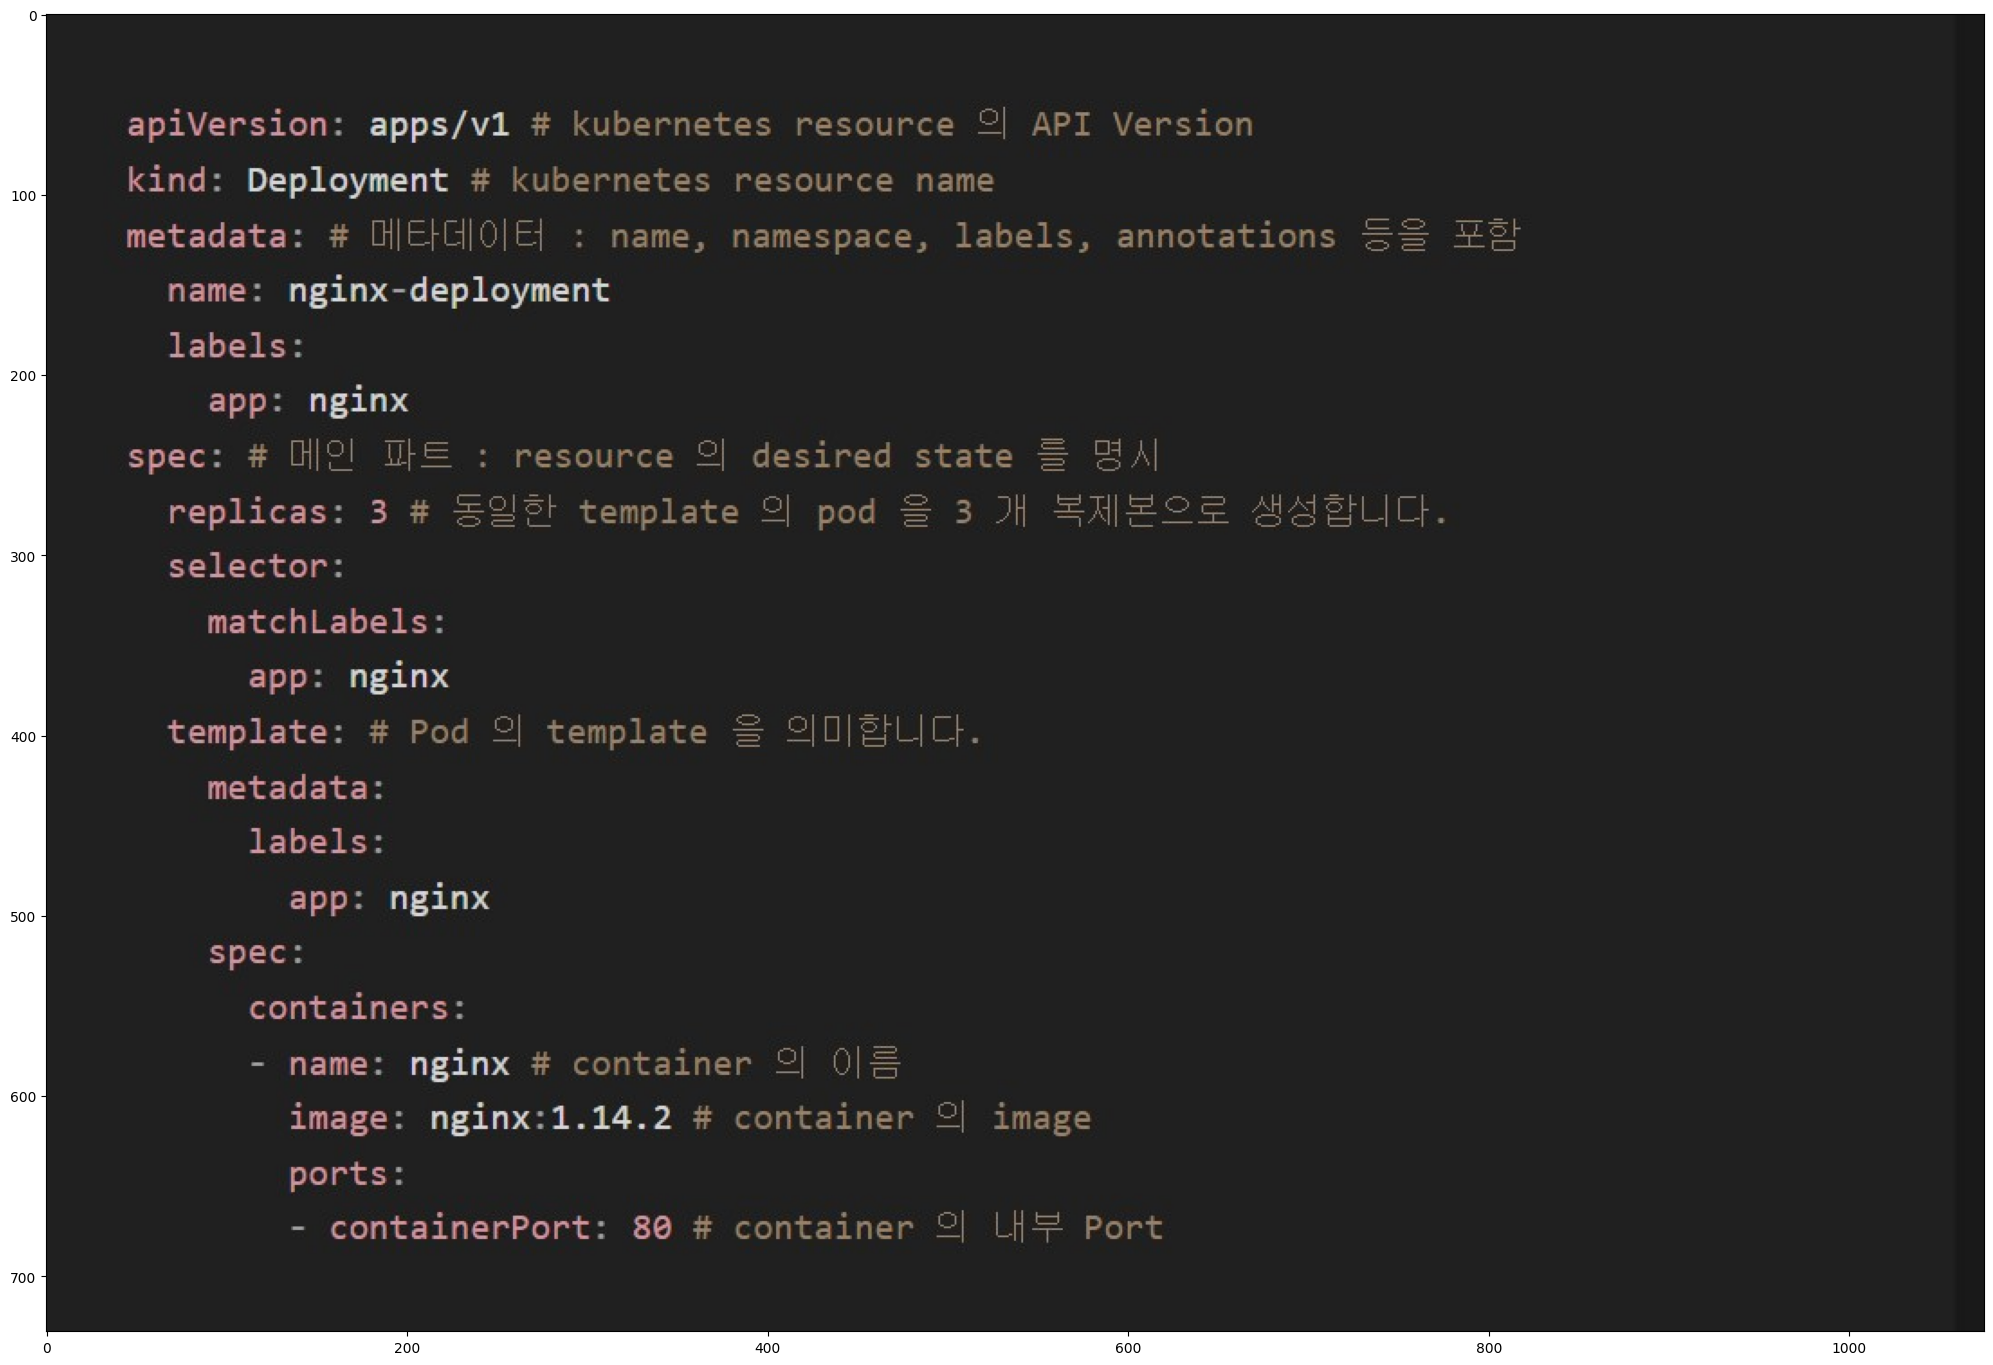

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

def display(start, end):
    for i in range(end+1):
        if i > start-1:
            GAP = cv2.imread(f'yaml{i}.jpg')
            GAP = cv2.cvtColor(GAP, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(25,25))
            plt.imshow(GAP)
            plt.show()

display(start=6, end=6)

In [2]:
# vi deployment.yaml
# # 위의 내용을 복사 후 붙여넣습니다.
!minikube start --driver=docker
!kubectl apply -f deployment.yaml

😄  minikube v1.22.0 on Ubuntu 20.04 (amd64)
✨  Using the docker driver based on existing profile
👍  Starting control plane node minikube in cluster minikube
🚜  Pulling base image ...
🏃  Updating the running docker "minikube" container ...
🐳  Preparing Kubernetes v1.21.2 on Docker 20.10.7 ...
🔎  Verifying Kubernetes components...
    ▪ Using image gcr.io/k8s-minikube/storage-provisioner:v5
🌟  Enabled addons: default-storageclass, storage-provisioner
🏄  Done! kubectl is now configured to use "minikube" cluster and "default" namespace by default
deployment.apps/nginx-deployment created


In [3]:
!kubectl get deployment

NAME               READY   UP-TO-DATE   AVAILABLE   AGE
nginx-deployment   3/3     3            3           69s


- 생성된 Pod 의 IP 를 확인하고 접속을 시도해봅니다.

- `curl -X GET <POD-IP> -vvv`
- `ping <POD-IP>`

In [5]:
# Pod 의 IP 를 확인합니다.
!kubectl get pod -o wide

!curl -X GET <POD-IP> -vvv

NAME                                READY   STATUS    RESTARTS   AGE     IP           NODE       NOMINATED NODE   READINESS GATES
nginx-deployment-66b6c48dd5-9nsx6   1/1     Running   0          4m31s   172.17.0.5   minikube   <none>           <none>
nginx-deployment-66b6c48dd5-h6xk4   1/1     Running   0          4m31s   172.17.0.4   minikube   <none>           <none>
nginx-deployment-66b6c48dd5-mtrwc   1/1     Running   0          4m31s   172.17.0.3   minikube   <none>           <none>


- ping 날리면 무기한 회신이 없는데 왜냐하면 외부 접근 IP가 아니라 내부 IP로 접근해야하기 때문임
- `할당된 <POD-IP> 는 클러스터 내부에서만 접근할 수 있는 IP 이기 때문에 외부에서는 Pod 에 접속할 수 없습니다.`

In [6]:
!ping 172.17.0.5

PING 172.17.0.5 (172.17.0.5) 56(84) bytes of data.
From 172.17.0.1 icmp_seq=1 Destination Host Unreachable
From 172.17.0.1 icmp_seq=2 Destination Host Unreachable
From 172.17.0.1 icmp_seq=5 Destination Host Unreachable
From 172.17.0.1 icmp_seq=6 Destination Host Unreachable
From 172.17.0.1 icmp_seq=7 Destination Host Unreachable
From 172.17.0.1 icmp_seq=8 Destination Host Unreachable
From 172.17.0.1 icmp_seq=9 Destination Host Unreachable
From 172.17.0.1 icmp_seq=10 Destination Host Unreachable
From 172.17.0.1 icmp_seq=11 Destination Host Unreachable
From 172.17.0.1 icmp_seq=12 Destination Host Unreachable
From 172.17.0.1 icmp_seq=13 Destination Host Unreachable
From 172.17.0.1 icmp_seq=14 Destination Host Unreachable
From 172.17.0.1 icmp_seq=15 Destination Host Unreachable
From 172.17.0.1 icmp_seq=16 Destination Host Unreachable
From 172.17.0.1 icmp_seq=18 Destination Host Unreachable
From 172.17.0.1 icmp_seq=19 Destination Host Unreachable
From 172.17.0.1 icmp_seq=20 Destination Host

- minikube 내부로 접속하면 통신이 되는지 확인해보겠습니다.
```minikube ssh
# minikube 내부로 접속합니다.

curl -X GET <POD-IP> -vvv
ping <POD-IP>
# 통신 가능
logout

In [7]:
!minikube ssh

Last login: Sun Jun 18 04:43:25 2023 from 192.168.49.1
]0;docker@minikube: ~docker@minikube:~$ ^C

]0;docker@minikube: ~docker@minikube:~$ 

- 외부에서도 접근할 수 있게 해야함
- 그럼 이제 위의 Deployment 를 매칭시킨 Service 를 생성해보겠습니다.
```
vi service.yaml
# 파일을 열어 위의 내용을 복사 붙여넣기 합니다.

apiVersion: v1
kind: Service
metadata:
  name: my-nginx
  labels:
    run: my-nginx
spec:
  type: NodePort # Service 의 Type 을 명시하는 부분입니다. 자세한 설명은 추후 말씀드리겠습니다.
  ports:
  - port: 80
    protocol: TCP
  selector: # 아래 label 을 가진 Pod 을 매핑하는 부분입니다.
    app: nginx 

:wq

kubectl apply -f service.yaml

kubectl get service
# PORT 80:<PORT> 숫자 확인

curl -X GET $(minikube ip):<PORT>
# 이렇게 서비스를 통해서 클러스터 외부에서도 정상적으로 pod 에 접속할 수 있는 것을 확인합니다.

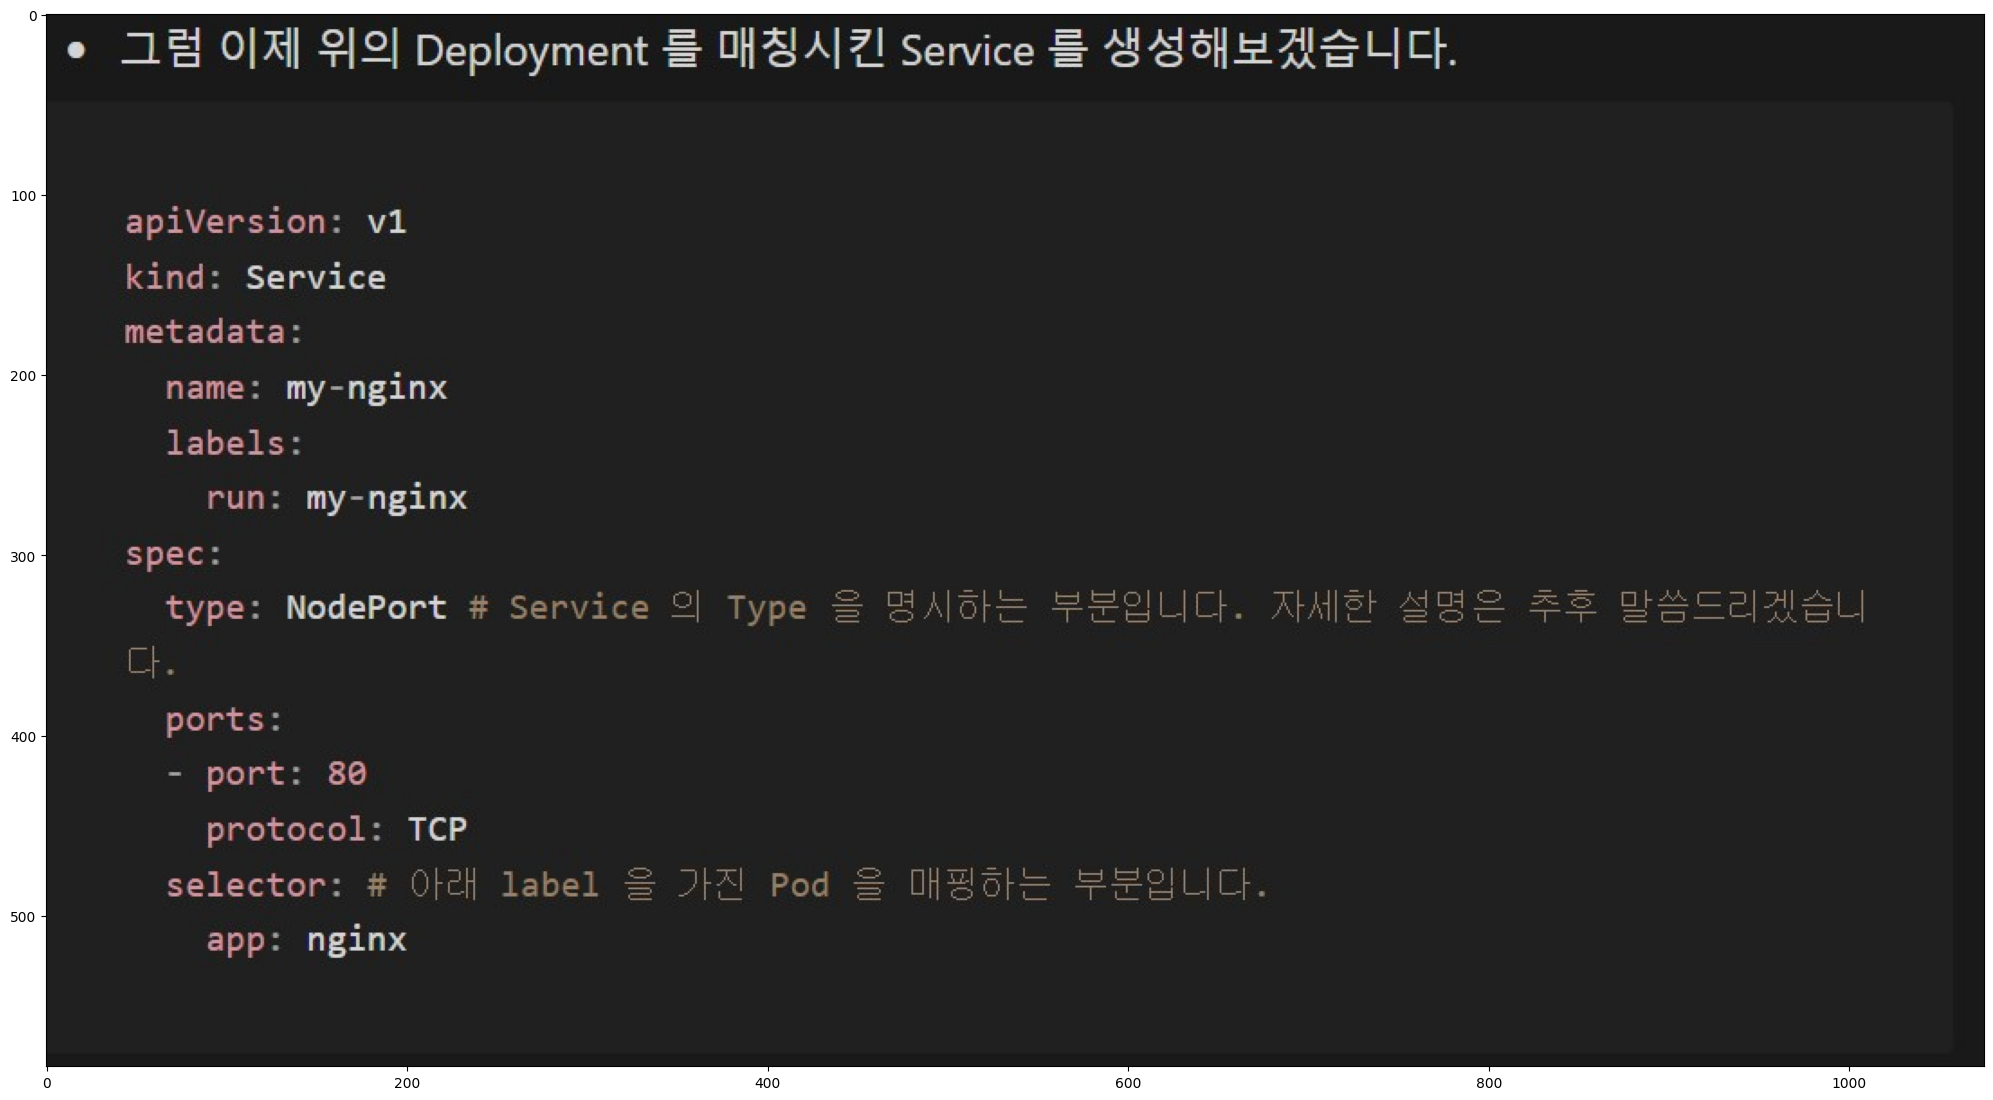

In [8]:
display(start=7, end=7)

In [9]:
!kubectl apply -f service.yaml

service/my-nginx created


- `**PORT 80:<PORT> 숫자 확인**`

In [10]:
!kubectl get service

NAME         TYPE        CLUSTER-IP      EXTERNAL-IP   PORT(S)        AGE
kubernetes   ClusterIP   10.96.0.1       <none>        443/TCP        11h
my-nginx     NodePort    10.97.218.136   <none>        80:32458/TCP   12s


In [11]:
!minikube ip

192.168.49.2


- 이렇게 서비스를 통해서 클러스터 외부에서도 정상적으로 pod 에 접속할 수 있는 것을 확인합니다.

In [12]:
!curl -X GET $(minikube ip):32458

<!DOCTYPE html>
<html>
<head>
<title>Welcome to nginx!</title>
<style>
    body {
        width: 35em;
        margin: 0 auto;
        font-family: Tahoma, Verdana, Arial, sans-serif;
    }
</style>
</head>
<body>
<h1>Welcome to nginx!</h1>
<p>If you see this page, the nginx web server is successfully installed and
working. Further configuration is required.</p>

<p>For online documentation and support please refer to
<a href="http://nginx.org/">nginx.org</a>.<br/>
Commercial support is available at
<a href="http://nginx.com/">nginx.com</a>.</p>

<p><em>Thank you for using nginx.</em></p>
</body>
</html>


- ### *** Service 의 Type 이란?**
    - #### **NodePort** 라는 type 을 사용했기 때문에, minikube 라는 kubernetes cluster 내부에 배포된 서비스에 클러스터 외부에서 접근할 수 있었습니다.
        - ##### 접근하는 IP 는 pod 이 떠있는 노드(머신)의 IP 를 사용하고, Port 는 할당받은 Port 를 사용합니다.
    - #### **LoadBalancer** 라는 type 을 사용해도, 마찬가지로 클러스터 외부에서 접근할 수 있지만, LoadBalancer 를 사용하기 위해서는 LoadBalancing 역할을 하는 모듈이 추가적으로 필요합니다.
    - #### **ClusterIP** 라는 type 은 고정된 IP, PORT 를 제공하지만, 클러스터 내부에서만 접근할 수 있는 대역의 주소가 할당됩니다.
    - #### **실무**에서는 주로 kubernetes cluster 에 MetalLB 와 같은 LoadBalancing 역할을 하는 모듈을 설치한 후, **LoadBalancer** type 으로 서비스를 expose 하는 방식을 사용합니다.
        - ##### NodePort 는 Pod 이 어떤 Node 에 스케줄링될 지 모르는 상황에서, Pod 이 할당된 후 해당 Node 의 IP 를 알아야 한다는 단점이 존재합니다.

- NodePort는 pod가 엄청나게 많으면 pod의 ip를 다 찾아야 되서 쓰기 어렵다